## Background

Corners are features which are distinctive and reasonably invariant to viewpoint. In flat regions, regardless of the direction in which we move the window, the gradient magnitude and orientation of pixels do not change. This means there is no distinctive key point (pixel) in this region, as all pixels are the same.

In edge regions, moving the window along the edge does not cause any change in pixel gradients. However, shifting the window perpendicular to the edge (in the direction of the pixel gradient) does make a change, though it is not sufficiently strong.

Corners, unlike flat and edge regions, yield a significant change in gradient magnitude and orientation when the window is shifted in any direction. This occurs because the pixel RGB (or Intensity) values in the window change substantially when shifted. This behavior makes corners useful for good localization. Therefore, corners in the image are the local features that the detector is looking for.

The basic approach is this: corners are detected by running a small window over an image. The detector window is designed to compute intensity changes. We are interested in three scenarios:

1. **Flat regions**: Areas of zero or small intensity changes in all directions (e.g., a constant region).
2. **Edges**: Areas of changes in one direction but small or no changes in the orthogonal direction (e.g., along a boundary).
3. **Corners**: Areas of significant changes in all directions (e.g., when the window contains a corner or isolated points).


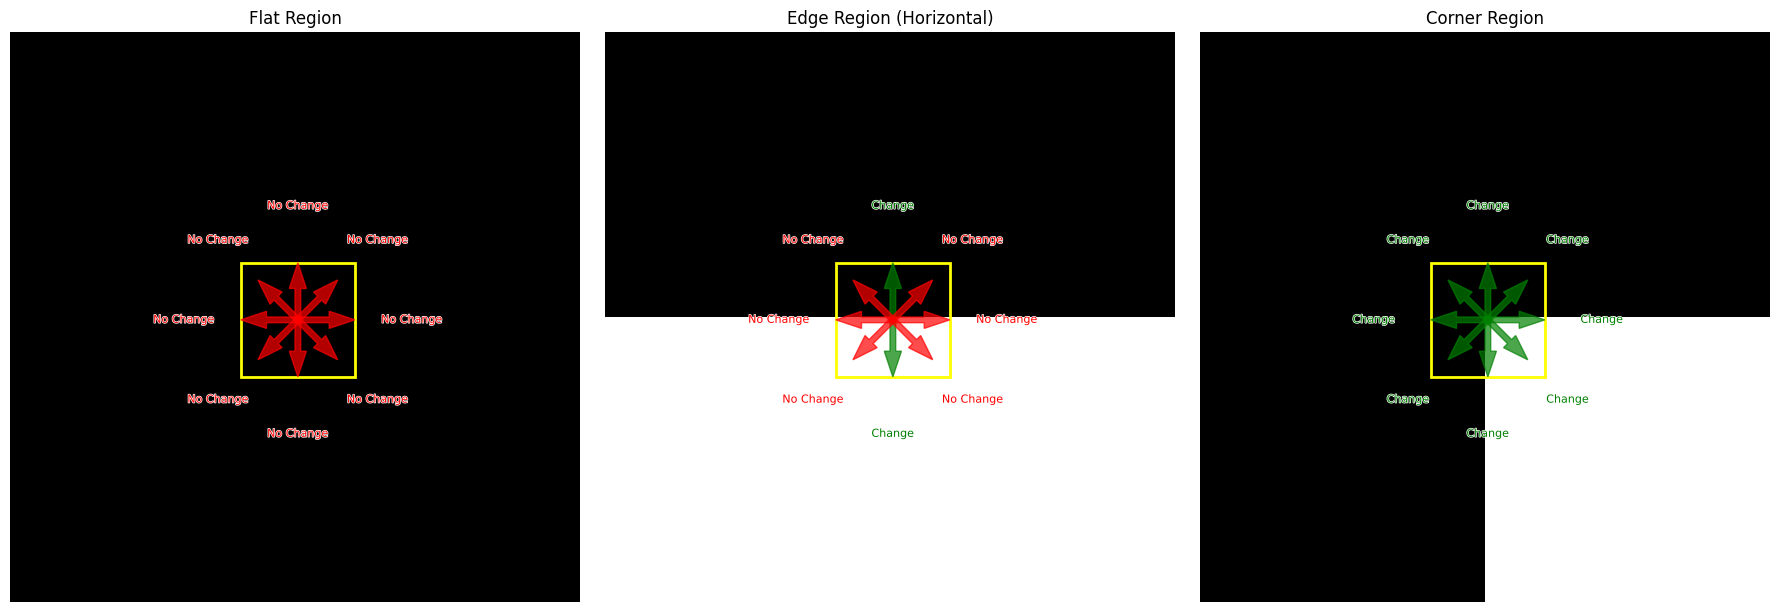

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

def create_flat_region(size=100):
    """Creates a flat (constant intensity) image."""
    return np.full((size, size), 128, dtype=np.uint8)

def create_edge_region(size=100, edge_position=50, orientation='horizontal'):
    """
    Creates an image with a single edge.
    orientation: 'horizontal' or 'vertical'
    """
    img = np.full((size, size), 128, dtype=np.uint8)
    if orientation == 'horizontal':
        img[edge_position:, :] = 200  # Bright on one side
    else:
        img[:, edge_position:] = 200
    return img

def create_corner_region(size=100, corner_position=(50, 50)):
    """Creates an image with a single corner."""
    img = np.full((size, size), 128, dtype=np.uint8)
    img[corner_position[0]:, corner_position[1]:] = 200
    return img

def draw_arrows(ax, center, directions, changes):
    """
    Draws arrows on the given axes centered at 'center'.
    directions: list of tuples indicating arrow directions (dx, dy)
    changes: list indicating if movement in that direction causes intensity change
    """
    cx, cy = center
    for (dx, dy), change in zip(directions, changes):
        color = 'green' if change else 'red'
        label = 'Change' if change else 'No Change'
        # Add path effects for better visibility
        arrow = patches.FancyArrow(
            cx, cy, dx, dy, 
            width=1, length_includes_head=True, 
            color=color, alpha=0.7
        )
        ax.add_patch(arrow)
        ax.text(
            cx + dx*2, cy + dy*2, label, 
            color=color, fontsize=8, ha='center', va='center',
            path_effects=[withStroke(linewidth=1, foreground="white")]
        )

def visualize_regions():
    # Define kernel properties
    kernel_size = 20
    kernel_half = kernel_size // 2

    # Define movement directions (up, down, left, right, diagonals)
    directions = [
        (0, -10),   # Up (negative y for upward direction)
        (0, 10),    # Down
        (-10, 0),   # Left
        (10, 0),    # Right
        (-7, -7),   # Up-Left
        (7, -7),    # Up-Right
        (-7, 7),    # Down-Left
        (7, 7)      # Down-Right
    ]

    # Create figures for Flat, Edge, Corner
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Flat Region
    flat_img = create_flat_region()
    ax = axs[0]
    ax.imshow(flat_img, cmap='gray')
    ax.set_title('Flat Region')
    ax.axis('off')

    # Calculate kernel center
    cx_flat, cy_flat = flat_img.shape[1]//2, flat_img.shape[0]//2

    # Draw kernel rectangle at center
    rect = patches.Rectangle(
        (cx_flat - kernel_half, cy_flat - kernel_half),
        kernel_size, kernel_size, linewidth=2, edgecolor='yellow', facecolor='none'
    )
    ax.add_patch(rect)

    # In Flat region, moving in any direction causes no change
    changes_flat = [False] * len(directions)
    draw_arrows(ax, (cx_flat, cy_flat), directions, changes_flat)

    # 2. Edge Region (Horizontal)
    edge_img = create_edge_region(orientation='horizontal')
    ax = axs[1]
    ax.imshow(edge_img, cmap='gray')
    ax.set_title('Edge Region (Horizontal)')
    ax.axis('off')

    # Calculate kernel center
    cx_edge, cy_edge = edge_img.shape[1]//2, edge_img.shape[0]//2

    # Draw kernel rectangle at edge
    rect = patches.Rectangle(
        (cx_edge - kernel_half, cy_edge - kernel_half),
        kernel_size, kernel_size, linewidth=2, edgecolor='yellow', facecolor='none'
    )
    ax.add_patch(rect)

    # In Horizontal edge, moving up/down changes intensity, left/right does not
    changes_edge = [
        True,   # Up
        True,   # Down
        False,  # Left
        False,  # Right
        False,  # Up-Left
        False,  # Up-Right
        False,  # Down-Left
        False   # Down-Right
    ]
    draw_arrows(ax, (cx_edge, cy_edge), directions, changes_edge)

    # 3. Corner Region
    corner_img = create_corner_region()
    ax = axs[2]
    ax.imshow(corner_img, cmap='gray')
    ax.set_title('Corner Region')
    ax.axis('off')

    # Calculate kernel center
    cx_corner, cy_corner = corner_img.shape[1]//2, corner_img.shape[0]//2

    # Draw kernel rectangle at corner
    rect = patches.Rectangle(
        (cx_corner - kernel_half, cy_corner - kernel_half),
        kernel_size, kernel_size, linewidth=2, edgecolor='yellow', facecolor='none'
    )
    ax.add_patch(rect)

    # In Corner region, moving in any direction changes intensity
    changes_corner = [True] * len(directions)
    draw_arrows(ax, (cx_corner, cy_corner), directions, changes_corner)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_regions()


## Mathematical Analysis of Harris Corner Detection

Let's first dive into the mathematical formulation of the Harris Corner Detector. 

### Patch Shifting and Intensity Changes

Consider a patch of size $w \times h$ centered at pixel $(s, t)$ in an image. Shifting this patch by $(x, y)$ results in a new patch located at $(s + x, t + y)$. The intensity values of the original and shifted patches can be denoted as $I(s, t)$ and $I(s + x, t + y)$, respectively.

The **weighted sum of squared differences** (SSD) between the original and shifted patches is given by:

$$
F(x, y) = \sum_{s} \sum_{t} w(s, t) \left[ I(s + x, t + y) - I(s, t) \right]^2 
$$

where $w(s, t)$ is a weighting function that assigns weight to each pixel within the patch.

### Taylor Series Expansion

To approximate the intensity of the shifted patch, we employ the **Taylor series expansion** around the point $(s, t)$:

$$
I(s + x, t + y) \approx I(s, t) + x \cdot I_x(s, t) + y \cdot I_y(s, t)
$$
    
where:
- $I_x(s, t) = \frac{\partial I}{\partial x} \bigg|_{(s, t)}$
- $I_y(s, t) = \frac{\partial I}{\partial y} \bigg|_{(s, t)}$

### Expanding the SSD

Substituting the Taylor expansion into equation above:

$$
F(x, y) = \sum_{s} \sum_{t} w(s, t) \left[ x \cdot I_x(s, t) + y \cdot I_y(s, t) \right]^2 
$$

This equation can be expressed in matrix form as:

$$
F(x, y) 
= 
\begin{bmatrix}
x & y
\end{bmatrix}
M
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

Here, $M$ is the **gradient covariance matrix** defined as:

$$
M = \sum_{s} \sum_{t} w(s, t)
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$


### Weighting Function $w(s, t)$

The weighting function $w(s, t)$ generally adopts one of the following forms:

1. **Box Filter:** Preferred when computational speed is paramount and the noise level is low.

   $$
   w(s, t) = 
   \begin{cases}
   1 & \text{if } (s, t) \text{ is inside the patch} \\
   0 & \text{otherwise}
   \end{cases}
   $$

2. **Gaussian Filter:** Employed when data smoothing is essential, providing better noise resistance.

   $$
   w(s, t) = e^{-\frac{s^2 + t^2}{2\sigma^2}}
   $$

### Eigenvalue Analysis

The matrix $M$, often referred to as the **Harris matrix**, is symmetric and can be analyzed using its eigenvalues and eigenvectors. The eigenvectors of the real and symmetric matrix, M point in the direction of maximum data spread with the eigenvalues being proportional to the data spread. This can be represented using eclipse, enclosing the data and eigenvalues representing the major and minor axes. By analyzing the eigenvalues of $M$, we can distinguish between flat regions, edges, and corners:

1. **Flat Regions:** Minimal intensity changes; the patch is nearly constant ($\lambda_1 \approx \lambda_2 \approx 0$)
2. **Edges:** Significant intensity changes in one direction; the patch contains an edge ($\lambda_1$ is large, $\lambda_2$ is small (or vice versa))
3. **Corners:** Significant intensity changes in all directions; the patch contains a corner (Both $\lambda_1$ and $\lambda_2$ are large)

### Corner Response Function

Instead of computing eigenvalues, which are computationally expensive, the HS detector uses a **corner response function** $R$ defined as:

$$
R = \det(M) - k \cdot (\text{trace}(M))^2 
$$

where:
- $\det(M) = \lambda_1 \lambda_2$ is the determinant of $M$.
- $\text{trace}(M) = \lambda_1 + \lambda_2$ is the trace of $M$.
- $k$ is an empirical constant, typically in the range $0 < k < 0.25$.

**Interpretation of $R$:**
- **Corners:** $R$ is large and positive, as both $\lambda_1$ and $\lambda_2$ are large.
- **Edges:** $R$ is negative, with one large and one small eigenvalue.
- **Flat Regions:** $R$ is near zero, with both eigenvalues being small.

The constant $k$ acts as a **sensitivity factor**. A smaller $k$ makes the detector more likely to identify corners, while a larger $k$ increases the threshold for corner detection.

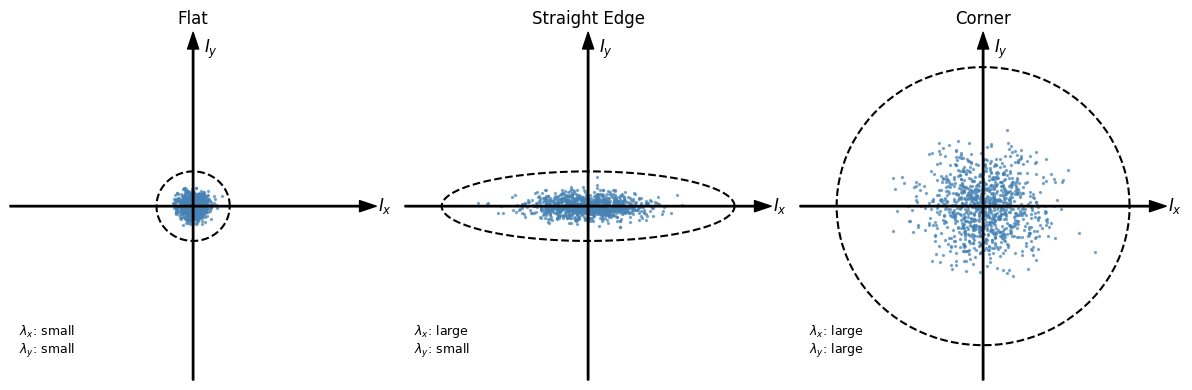

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create ellipses based on the eigenvalues
def plot_ellipse(ax, lambda_x, lambda_y, title):
    t = np.linspace(0, 2*np.pi, 100)
    x = lambda_x * np.cos(t)
    y = lambda_y * np.sin(t)
    
    # Plot the ellipse
    ax.plot(x, y, 'k--')  # Dashed ellipse
    
    # Simulate the scatter points inside the ellipse
    scatter_x = np.random.normal(0, lambda_x / 5, 1000)
    scatter_y = np.random.normal(0, lambda_y / 5, 1000)
    ax.scatter(scatter_x, scatter_y, s=2, color='steelblue', alpha=0.6)
    
    # Set limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    
    # Draw arrows for axes through the origin with labels
    ax.annotate('', xy=(1, 0), xytext=(-1, 0),
                arrowprops=dict(facecolor='black', shrink=0, width=1, headwidth=8))
    ax.annotate('', xy=(0, 1), xytext=(0, -1),
                arrowprops=dict(facecolor='black', shrink=0, width=1, headwidth=8))
    
    # Labels for the arrows
    ax.text(1.05, 0, r'$I_x$', fontsize=12, ha='center', va='center')
    ax.text(0.1, 0.9, r'$I_y$', fontsize=12, ha='center', va='center')
    
    ax.set_title(title)

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Flat
plot_ellipse(axs[0], 0.2, 0.2, 'Flat')
axs[0].text(-0.95, -0.85, r'$\lambda_x$: small' + '\n' + r'$\lambda_y$: small', fontsize=9)
axs[0].axis('off')

# Straight Edge
plot_ellipse(axs[1], 0.8, 0.2, 'Straight Edge')
axs[1].text(-0.95, -0.85, r'$\lambda_x$: large' + '\n' + r'$\lambda_y$: small', fontsize=9)
axs[1].axis('off')

# Corner
plot_ellipse(axs[2], 0.8, 0.8, 'Corner')
axs[2].text(-0.95, -0.85, r'$\lambda_x$: large' + '\n' + r'$\lambda_y$: large', fontsize=9)
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [259]:
# Load the image in grayscale
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return image

In [260]:
# Step 1 : Compute Image Derivatives, Ix and Iy
def compute_image_gradients(image):
    # Compute the gradients in x and y direction
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return Ix, Iy

In [261]:
# Step 2: Computing Ix^2, Iy^2, IxIy
def compute_squared_gradients(Ix, Iy):
    Ix2 = Ix**2
    Iy2 = Iy**2
    IxIy = Ix * Iy
    return Ix2, Iy2, IxIy

In [290]:
# Step 3: Applying Gaussian filter to the computed gradients to filter out sudden variations 
def apply_gaussian_filter(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

In [263]:
# Step 4: Compute the Harris Matrix
def compute_harris_matrix(Sxx, Syy, Sxy):
    M = np.zeros((2, 2))
    M[0, 0] = Sxx ; M[0, 1] = Sxy
    M[1, 0] = Sxy ; M[1, 1] = Syy
    return M 

In [264]:
# Step 5: Compute the Harris Response
def compute_harris_response(M, k=0.05):
    det_M = np.linalg.det(M)
    trace_M = np.trace(M)
    R = det_M - k * (trace_M**2)
    return R

In [265]:
# Step 6: Compute the Harris Response for each pixel, given Sxx, Syy, Sxy
def harris_response_matrix(Sxx,Syy,Sxy,k = 0.05):
    R = np.zeros(Sxx.shape)
    for i in range(Sxx.shape[0]):
        for j in range(Sxx.shape[1]):
            M = compute_harris_matrix(Sxx[i,j],Syy[i,j],Sxy[i,j])
            R[i,j] = compute_harris_response(M,k)
    return R

In [281]:
# Step 7: Thresholding the response
def threshold_response(R, threshold_ratio = 0.01):
    corners = np.zeros_like(R)
    corners[R > threshold_ratio * R.max()] = 1
    return corners

After thresholding the corner response function, non-maximum suppression is applied to retain only the local maxima. This process ensures that only the strongest corners are detected. As mentioned in the paper, a corner region pixel (ie. one with a positive response) is selected as a nominated corner pixel if its response is an 8 way local maximum within a m x m window.

In [282]:
# Step 7: Non-maximum suppression
def non_max_suppression(R, corners, window_size=3):
    final_corners = []
    offset = window_size // 2
    for i in range(offset, R.shape[0] - offset):
        for j in range(offset, R.shape[1] - offset):
            if corners[i, j]:
                window = R[i - offset:i + offset + 1, j - offset:j + offset + 1]
                if R[i, j] == np.max(window):
                    final_corners.append((j, i)) 
    return final_corners


In [283]:
# Draw the corners on the image
def draw_corners(image, corners, color=(0, 0, 255), marker_size=1):
    # Convert grayscale to BGR for colored markers
    img_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for corner in corners:
        cv2.circle(img_with_corners, corner, marker_size, color, 1)
    return img_with_corners


In [302]:
def Harris_Corner_Detection(image_path, threshold=0.0001, k=0.1, window_size=3, 
                            gaussian_kernel_size=5, sigma=1.0):
    
    plt.figure(figsize=(20, 20))
    step = 1
    
    # Step 0: Load Image
    image = load_image(image_path)
    plt.subplot(4, 3, step)
    plt.imshow(image, cmap='gray')
    plt.title('Original Grayscale Image')
    plt.axis('off')
    step += 1
    
    # Step 1: Compute Image Gradients
    Ix, Iy = compute_image_gradients(image)
    # Normalize gradients for visualization
    Ix_display = cv2.normalize(Ix, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    Iy_display = cv2.normalize(Iy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.subplot(4, 3, step)
    plt.imshow(Ix_display, cmap='gray')
    plt.title('Gradient in X (Ix)')
    plt.axis('off')
    step += 1
    
    plt.subplot(4, 3, step)
    plt.imshow(Iy_display, cmap='gray')
    plt.title('Gradient in Y (Iy)')
    plt.axis('off')
    step += 1
    
    # Step 2: Compute Squared Gradients
    Ix2, Iy2, IxIy = compute_squared_gradients(Ix, Iy)
    # Normalize for visualization
    Ix2_display = cv2.normalize(Ix2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    Iy2_display = cv2.normalize(Iy2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    IxIy_display = cv2.normalize(IxIy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.subplot(4, 3, step)
    plt.imshow(Ix2_display, cmap='gray')
    plt.title('Squared Gradient Ix²')
    plt.axis('off')
    step += 1
    
    plt.subplot(4, 3, step)
    plt.imshow(Iy2_display, cmap='gray')
    plt.title('Squared Gradient Iy²')
    plt.axis('off')
    step += 1
    
    plt.subplot(4, 3, step)
    plt.imshow(IxIy_display, cmap='gray')
    plt.title('Product Gradient IxIy')
    plt.axis('off')
    step += 1
    
    # Step 3: Apply Gaussian Filter
    Sxx = apply_gaussian_filter(Ix2, gaussian_kernel_size, sigma)
    Syy = apply_gaussian_filter(Iy2, gaussian_kernel_size, sigma)
    Sxy = apply_gaussian_filter(IxIy, gaussian_kernel_size, sigma)
    
    # Normalize for visualization
    Sxx_display = cv2.normalize(Sxx, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    Syy_display = cv2.normalize(Syy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    Sxy_display = cv2.normalize(Sxy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.subplot(4, 3, step)
    plt.imshow(Sxx_display, cmap='gray')
    plt.title('Smoothed Sxx')
    plt.axis('off')
    step += 1
    
    plt.subplot(4, 3, step)
    plt.imshow(Syy_display, cmap='gray')
    plt.title('Smoothed Syy')
    plt.axis('off')
    step += 1
    
    plt.subplot(4, 3, step)
    plt.imshow(Sxy_display, cmap='gray')
    plt.title('Smoothed Sxy')
    plt.axis('off')
    step += 1
    
    # Step 4: Compute Harris Response
    R = harris_response_matrix(Sxx, Syy, Sxy, k)
    # Normalize R for visualization
    R_display = cv2.normalize(R, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.subplot(4, 3, step)
    plt.imshow(R_display, cmap='jet')
    plt.title('Harris Response R')
    plt.axis('off')
    step += 1
    
    # Step 5: Thresholding
    corners_binary = threshold_response(R, threshold)
    
    plt.subplot(4, 3, step)
    plt.imshow(corners_binary, cmap='gray')
    plt.title('Thresholded Corners (Binary)')
    plt.axis('off')
    step += 1
    
    # Step 6: Non-Maximum Suppression
    corners = non_max_suppression(R, corners_binary, window_size)
    
    # Step 7: Draw Corners on Image
    img_with_corners = draw_corners(image, corners)
    
    plt.subplot(4, 3, step)
    plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    plt.title('Detected Corners')
    plt.axis('off')
    step += 1
    
    total_subplots = 4 * 3  # 4 rows x 3 columns = 12 subplots
    while step <= total_subplots:
        plt.subplot(4, 3, step)
        plt.axis('off')
        step += 1
    
    plt.tight_layout()
    plt.show()
    
    return img_with_corners


In [303]:
# Using OpenCV's Harris Corner Detection
def harris_corner_detection_opencv(image_path, block_size=3, ksize=3, k=0.1, threshold=0.0001):
    # Load the image
    image = load_image(image_path)
    
    # Detect corners using Harris Corner Detection
    corners = cv2.cornerHarris(image, block_size, ksize, k)
    
    # Threshold the corners
    corners_binary = np.zeros_like(corners)
    corners_binary[corners > threshold * corners.max()] = 1
    
    # Non-maximum suppression
    corners = non_max_suppression(corners, corners_binary, window_size=3)
    
    # Draw corners on the image
    img_with_corners = draw_corners(image, corners)
    
    return img_with_corners

In [312]:
# Compare function for opencv and custom 

def compare_harris_corner_detection(image_path, block_size=3, ksize=3, k=0.1, threshold=0.0001):
    A = Harris_Corner_Detection(image_path)  # Your custom implementation
    B = harris_corner_detection_opencv(image_path)  # OpenCV implementation
    
    # Create 2 subplots A and B 
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))

    # Plot A
    axs[0].imshow(cv2.cvtColor(A, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Custom Harris Corner Detection')
    axs[0].axis('off')

    # Plot B
    axs[1].imshow(cv2.cvtColor(B, cv2.COLOR_BGR2RGB))
    axs[1].set_title('OpenCV Harris Corner Detection')
    axs[1].axis('off')

    # Draw a vertical line between the two subplots
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()


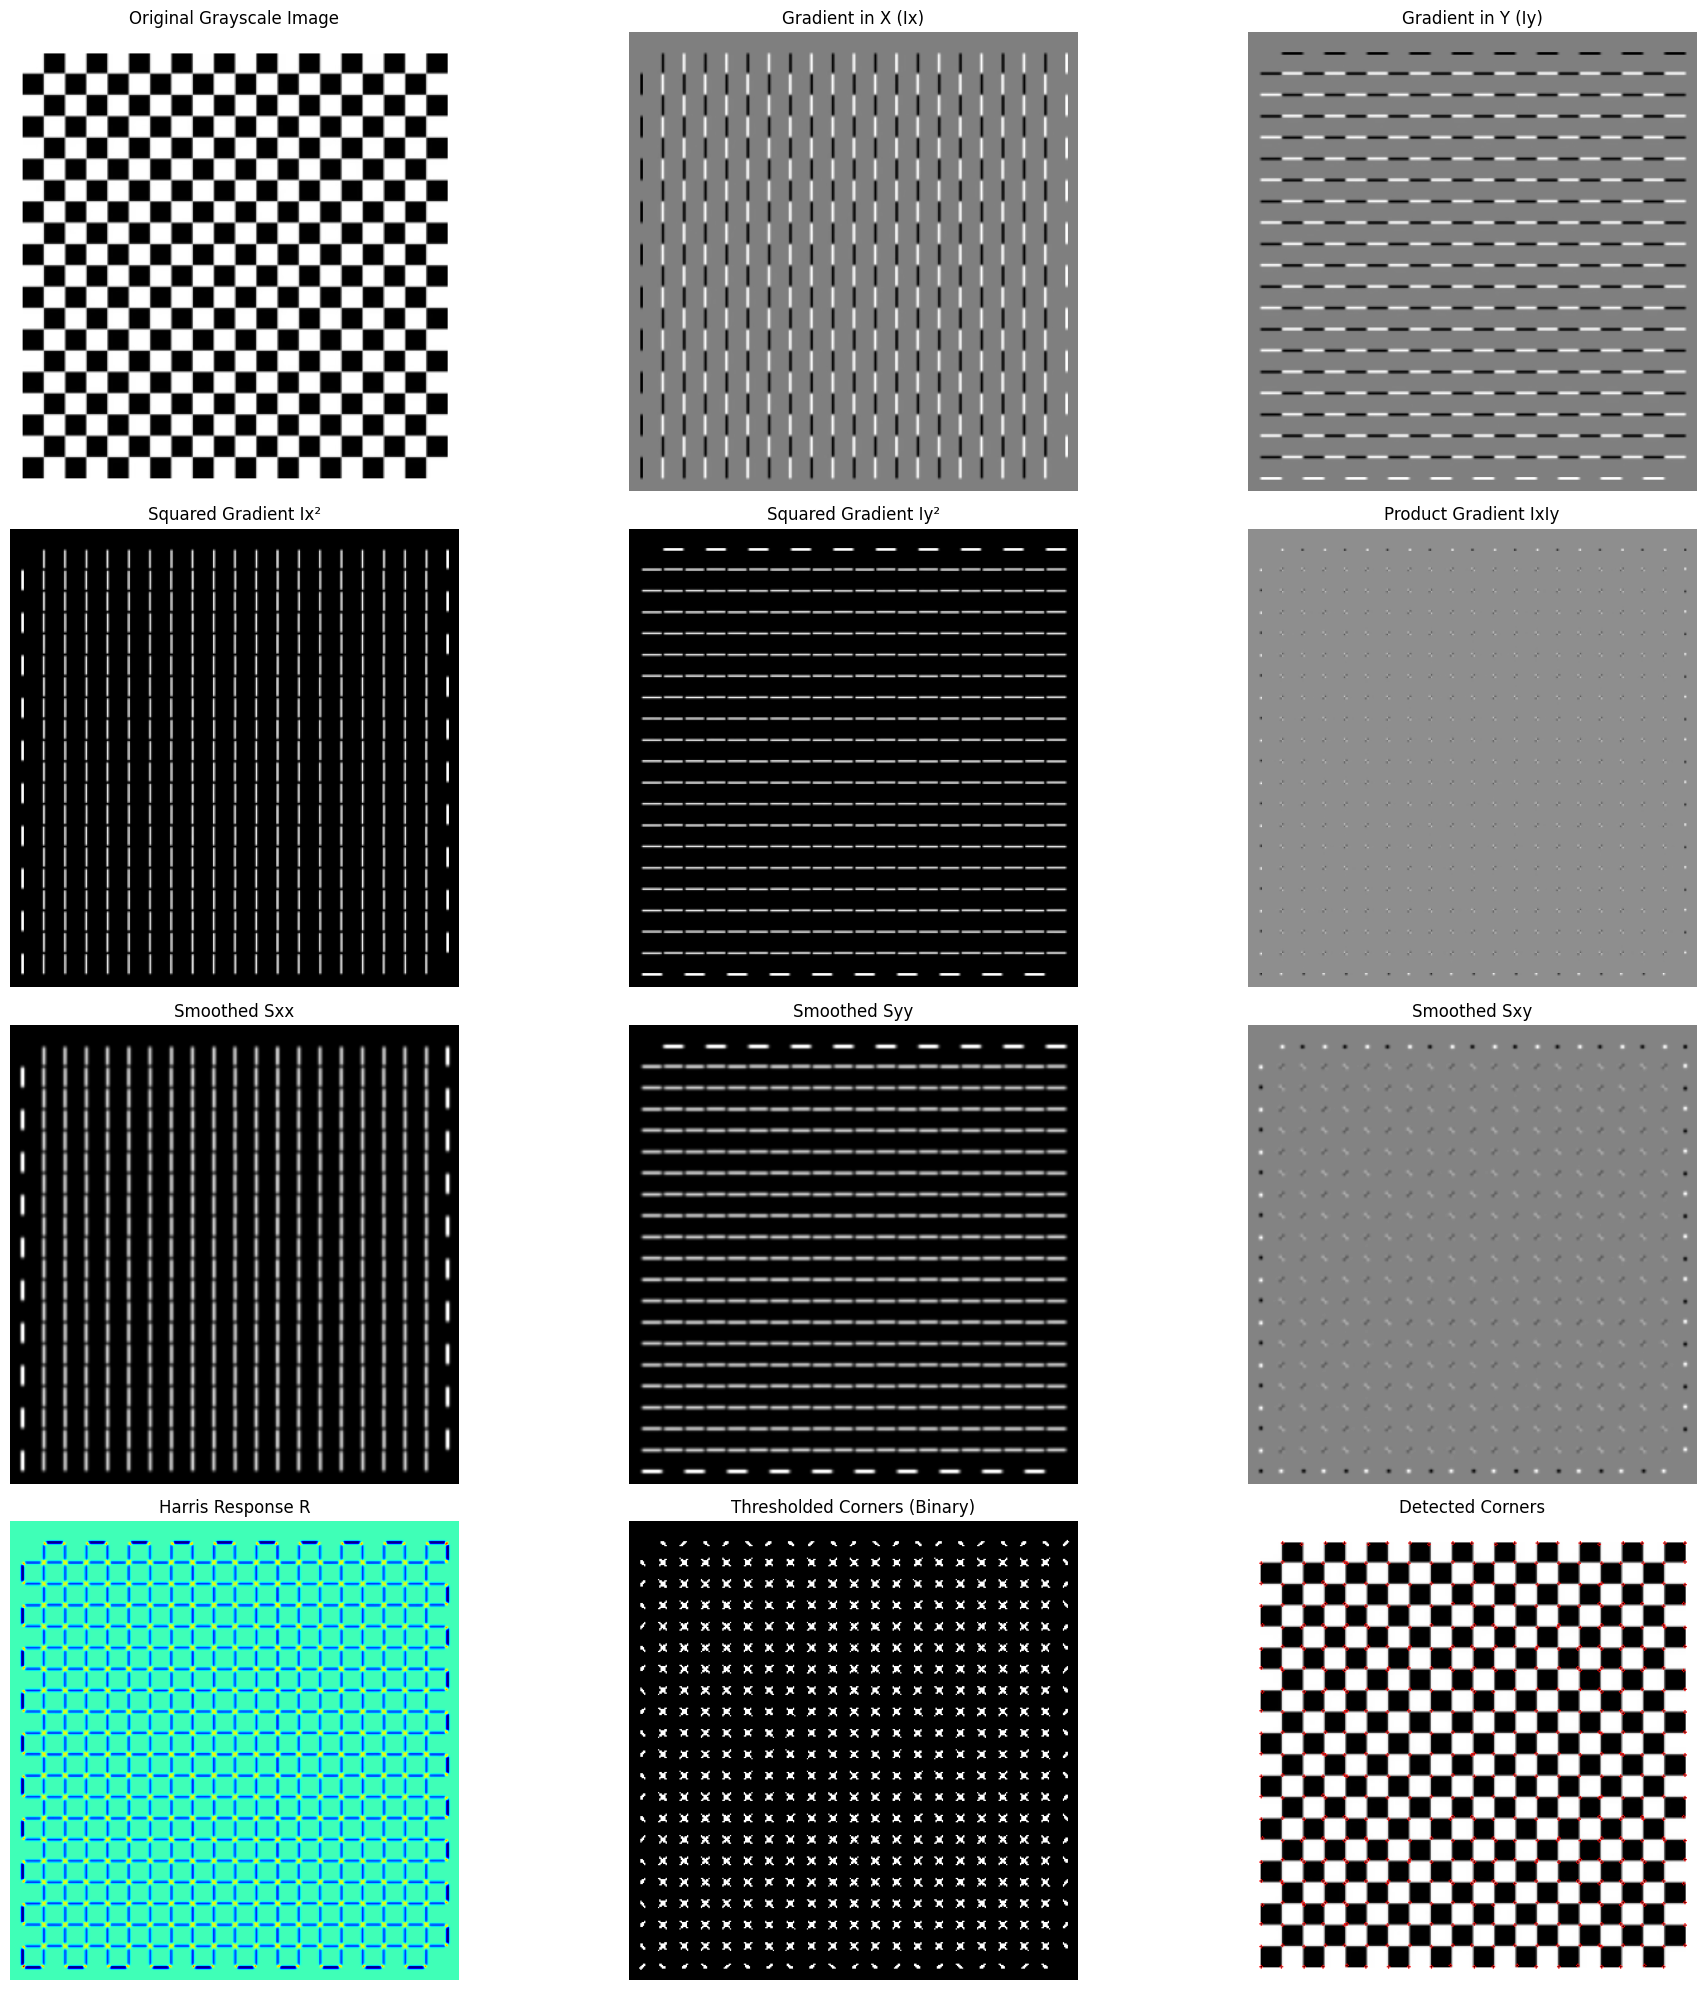

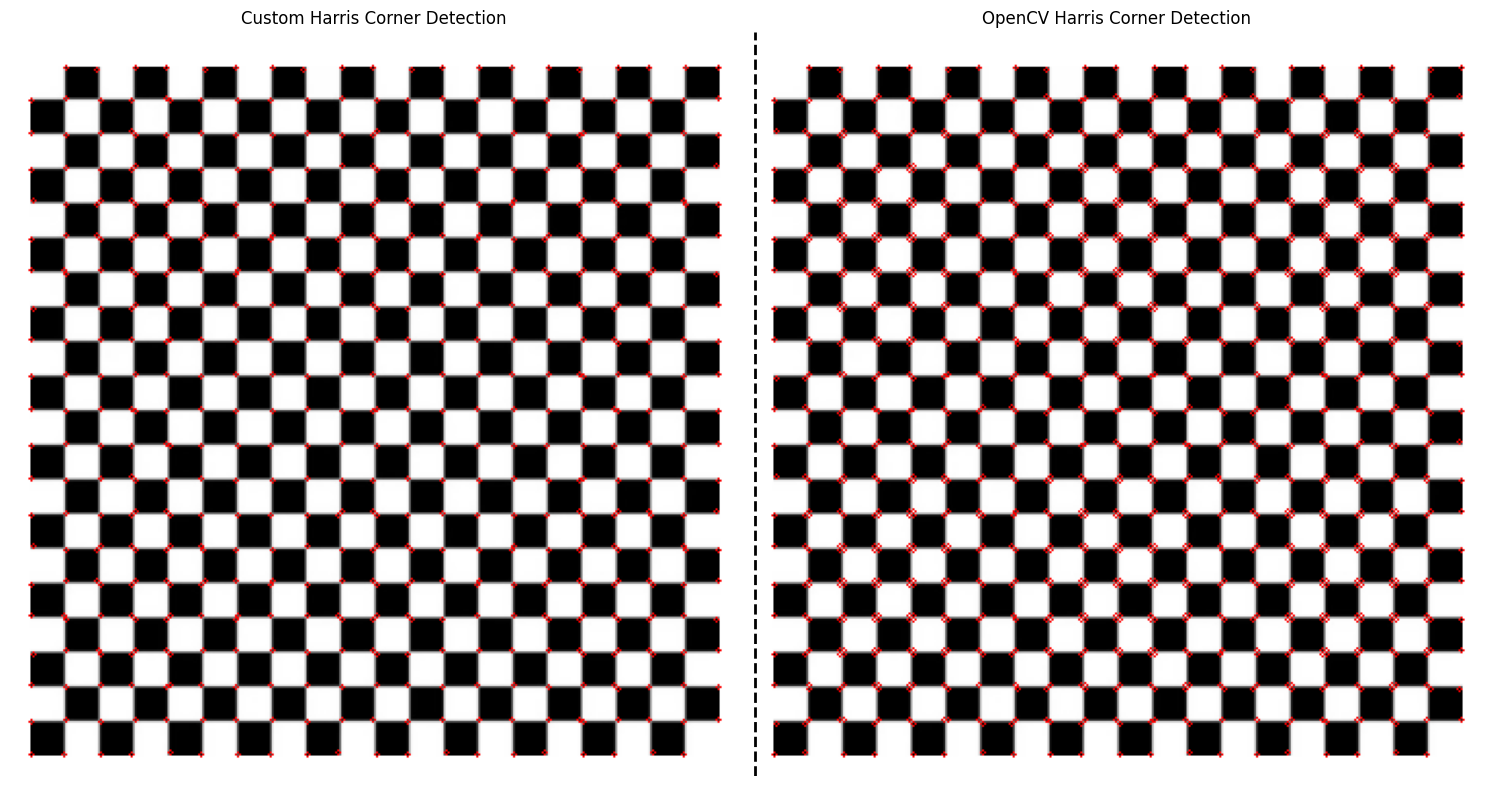

In [315]:
compare_harris_corner_detection('Board.png')

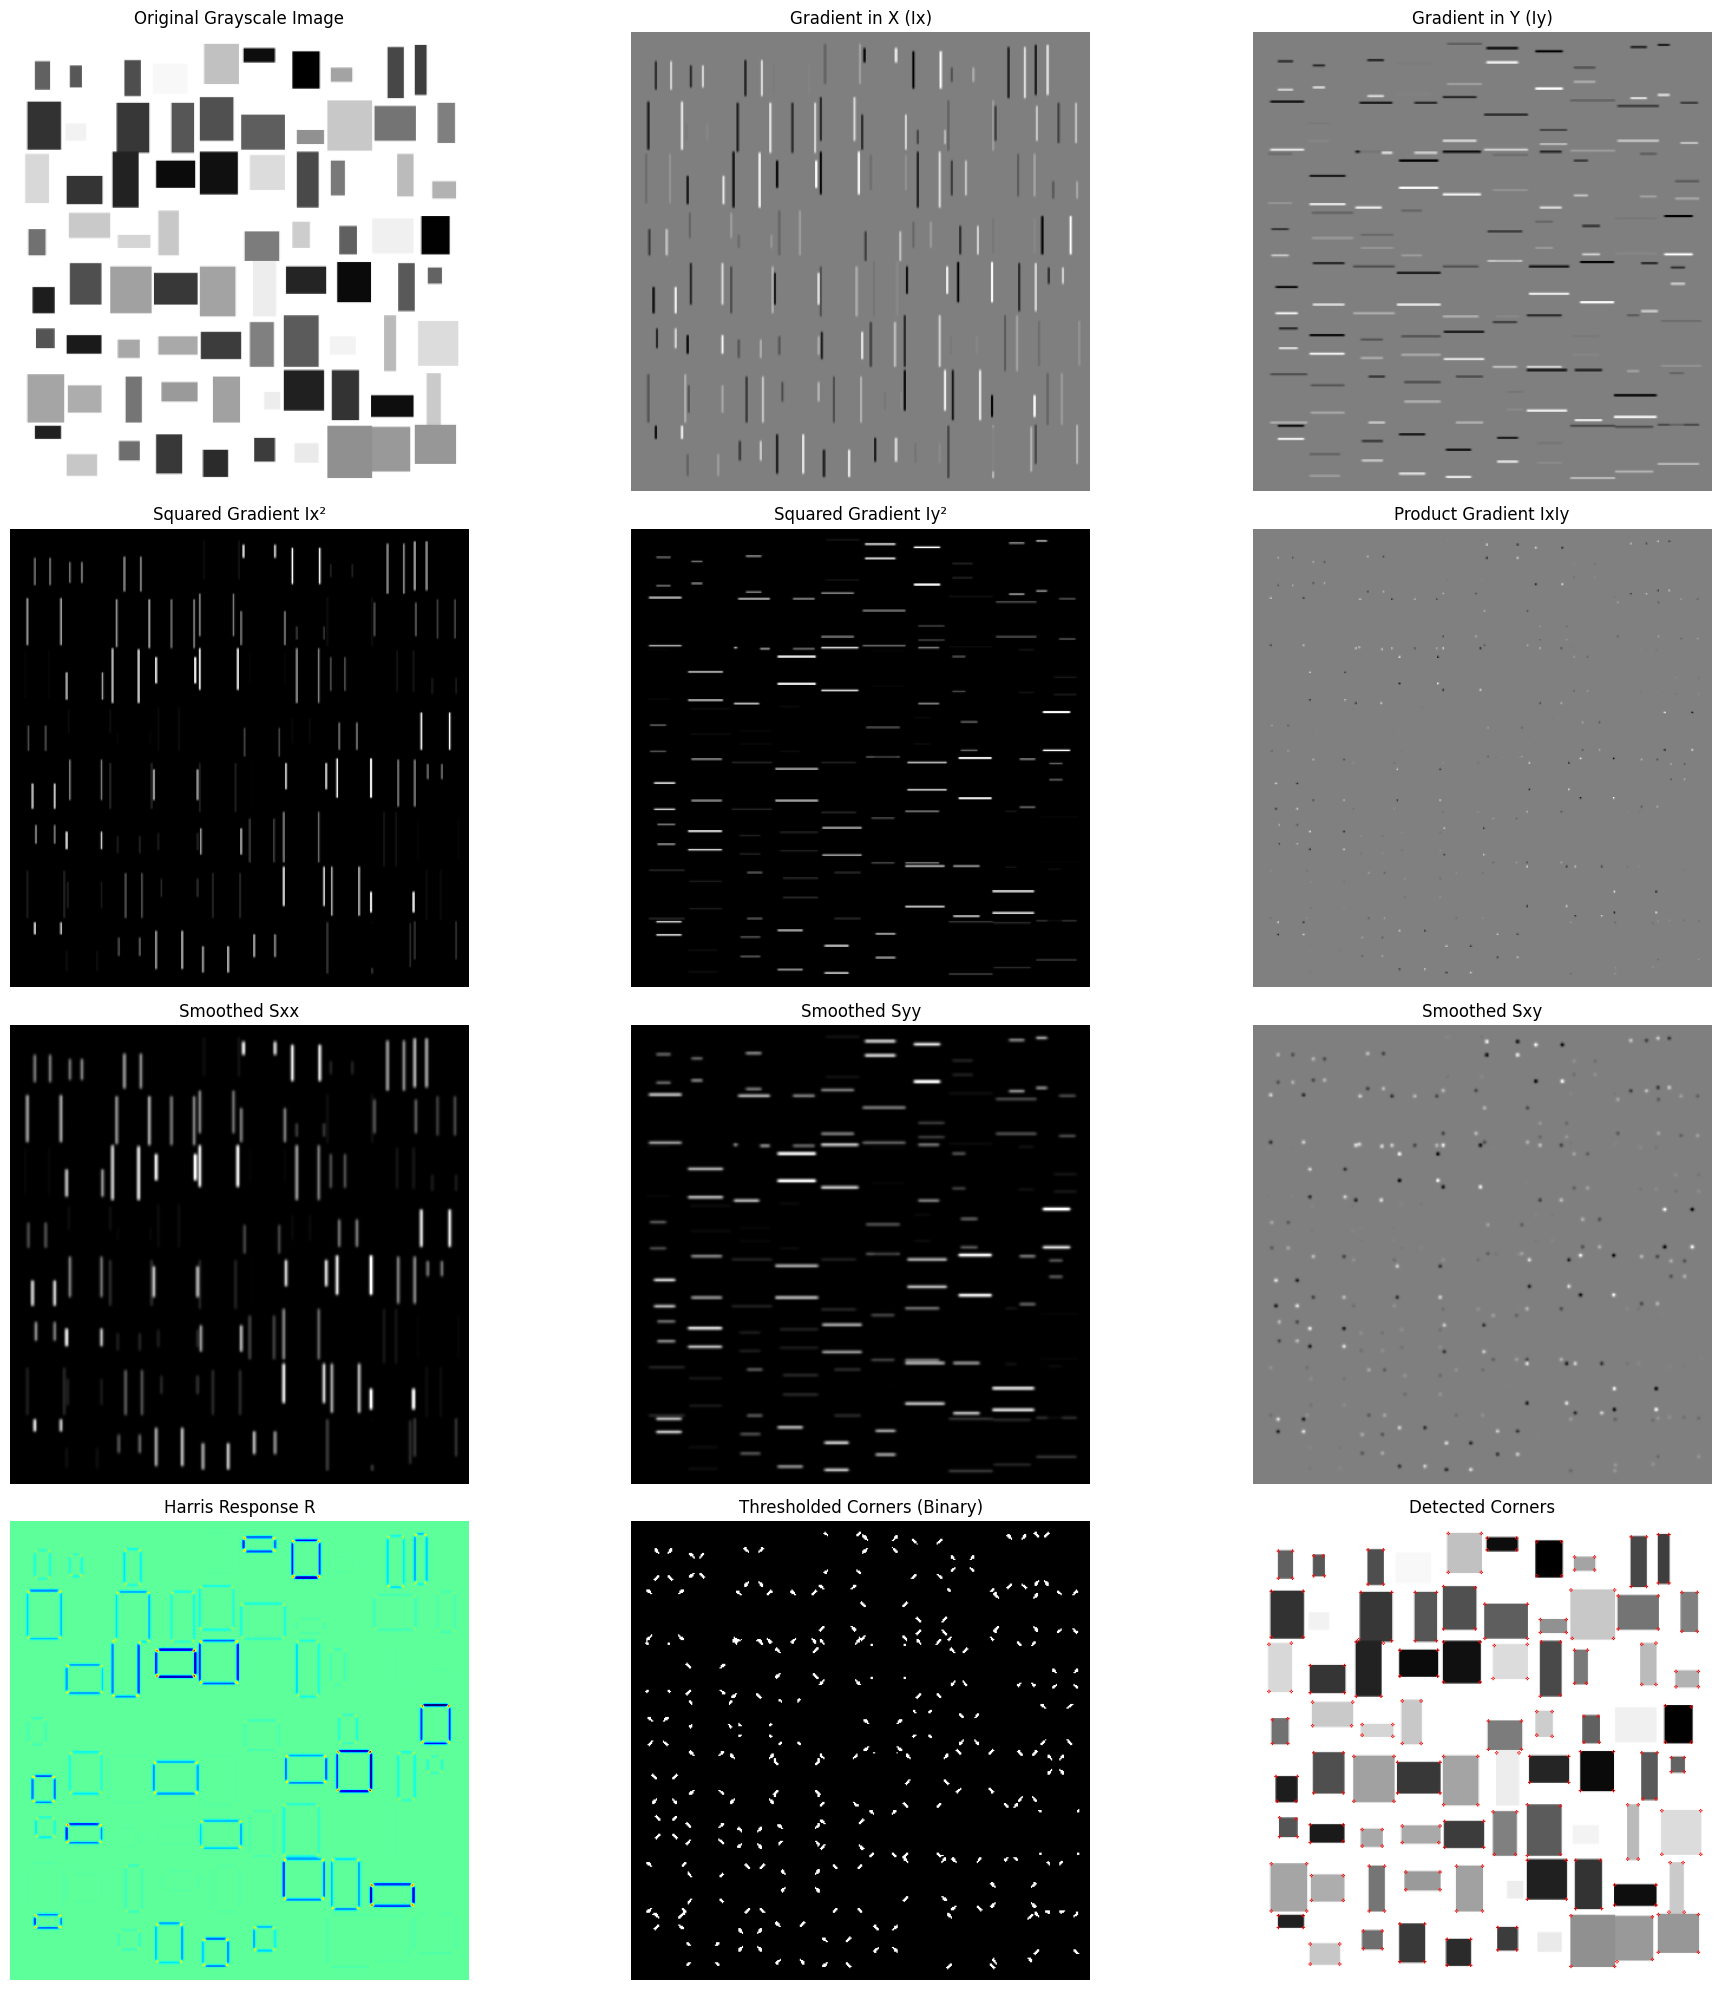

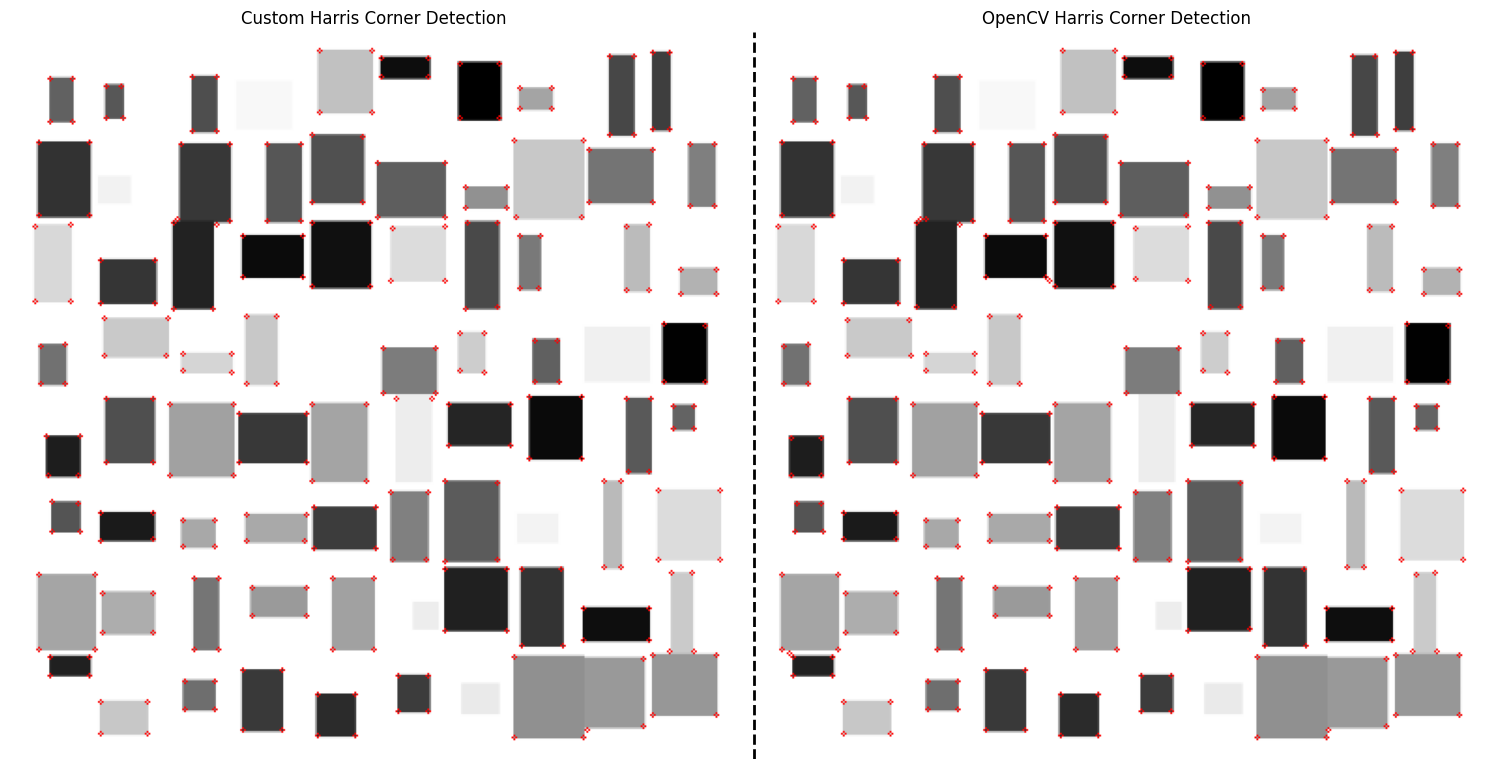

In [314]:
compare_harris_corner_detection('Grid.png', block_size=3, ksize=3, k=0.1, threshold=0.0001)